In [1]:
from experiment.api import mlflow as mlflow_api
from experiment.utils import transformation

import pandas as pd
import numpy as np
import pathlib
import json
import collections

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
LOG_MODEL_RUN = False

In [2]:
mlflow = mlflow_api.MLFlow()

# clean the environment without garbage collection
mlflow.clean()

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [3]:
# run the tracking server in background
mlflow.run_server()

In [4]:
model_config_path = (
    transformation.get_project_root() / "data" / "input" / "model_config" / "nlp_experiment.json"
)
model_config = mlflow.get_model_config(model_config_path)

In [5]:
clean_annotations = pd.read_csv(
    transformation.get_project_root() / "data" / "output" / "clean_annotations.csv"
)

# skip the last report
sentences = clean_annotations["relevant_text"].to_list()[:-1]
clean_labels = clean_annotations["classifications"].to_list()[:-1]

In [6]:
item_counts = collections.Counter(clean_annotations["classifications"].to_list())

# 1. Emergency
# 2. Normal
# 3. Non Emergency [Doctor]
# 4. Non Emergency [No Doctor]
for item, count in item_counts.items():
    print(f"Item {item} occurs {count} times in the list.")

Item 1 occurs 15 times in the list.
Item 3 occurs 24 times in the list.
Item 0 occurs 6 times in the list.
Item 2 occurs 8 times in the list.


In [7]:
sentences[:5]

['Kontrastsız Beyin BT Kafa kaidesi ve kalvarial kemik yapılar normal sınırlardadır. 4.ventrikül ve bazal sisternalar normal genişliktedir. Posterior fossa oluşumları olağandır. İntrakranial hipo veya hiperdens sınırlanabilen patoloji saptanmadı. 3.ventrikül orta hatta ve normal genişliktedir. Lateral ventriküller olağandır. Beyin orta hat yapılarında yer değiştirme saptanmamıştır. Serebral sulkuslar olağandır. Nazal septum sola deviye görünümdedir ve BTye yansıyan tipik bir akut iskemi bulgusu mevcut değildir.  Ancak bu konuda klinik kuşku varsa olgunun diffüzyon MRG ile değerlendirilmesi ve detaylandırılması daha yararlı olacaktır. ',
 'Sol serebellar hemisferde sekel ??? ensefalomalazi sahaları ve eski iskemi sekeli değişiklikler izlenmektedir. Sağ serebellar hemisfer düzeyinde de benzer bulgular izlenmekle birlikte her iki serebellumda atrofi bulguları ve folyolarda belirginleşme mevcuttur. Supratentorial kesitlerin değerlendirilmesinde 3. ve lateral ventrikul, konveksite sulkuslar

In [8]:
clean_sentences = transformation.sentence_cleaning_pipeline(sentences)
max_input_length = transformation.find_longest_sentence_length(clean_sentences)

mlflow.set_model_config(model_config_path, {"max_input_length": max_input_length})

In [9]:
# sentence count
print(f"clean sentences: {len(clean_sentences)}")
clean_sentences[:5]

clean sentences: 52


['kontrast beyin bt kafa kaide kalvarial kemik yapı normal sınır 4 ventrikül bazal sisternalar normal genişlik posterior fossa oluşum olağan i̇ntrakranial hipo hiperdens sınırlanabilen patoloji 3 ventrikül orta hatta normal genişlik lateral ventrikül olağan beyin orta hat yapı yer değiş sapta serebral sulkus olağan nazal septum sol deviye görünüm btye yansı tipik bir akut iskemi bulgu mevcut değil ancak konu klinik kuşku var olgu diffüzyon mrg değer detaylandırılması yarar ol',
 'sol serebellar hemisfer sekel ensefalomalazi saha eski iskemi sekel değişik izle sağ serebellar hemisfer düzey benzer bulgu izle birlikte iki serebellumda atrofi bulgu folyo belirgin mevcut supratentorial kesit değerlendirilmesin 3 lateral ventrikul konveksite sulkus atrofiye sekonder belirgin sağ posterior serebral arter sula saha kronik iskemik sekel gliozis saha varlık mevcut periventrikuler lökoriazis alan izle',
 'periventriküler derin beyaz cevher kronik iskemik gliozise bağ dansite kayıp izle bazal sist

In [10]:
# # manual test the word lemmatizer
# import simplemma
# word = "hemisferde"
# simplemma.lemmatize(word, lang="tr").lower()

In [11]:
training_size = int(len(clean_sentences) * model_config["training_percent"] / 100)
training_sentences = clean_sentences[0:training_size]
testing_sentences = clean_sentences[training_size:]
training_labels = clean_labels[0:training_size]
testing_labels = clean_labels[training_size:]

In [12]:
tokenizer = Tokenizer(
    num_words=model_config["vocab_size"], oov_token=model_config["oov_token"]
)

tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences,
    maxlen=max_input_length,
    padding=model_config["padding_type"],
    truncating=model_config["trunc_type"],
)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences,
    maxlen=max_input_length,
    padding=model_config["padding_type"],
    truncating=model_config["trunc_type"],
)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [13]:
tokenizer_path =  transformation.get_project_root() / "tmp" / "data" / 'tokenizer.json'

with open(tokenizer_path, 'w') as file:
    file.write(tokenizer.to_json())

In [14]:
# training_padded

In [15]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            model_config["vocab_size"],
            model_config["embedding_dim"],
            input_length=max_input_length,
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                        

In [17]:
history = model.fit(
    training_padded,
    training_labels,
    epochs=model_config["num_epochs"],
    batch_size=model_config["batch_size"],
    validation_data=(testing_padded, testing_labels),
    verbose=None,
)

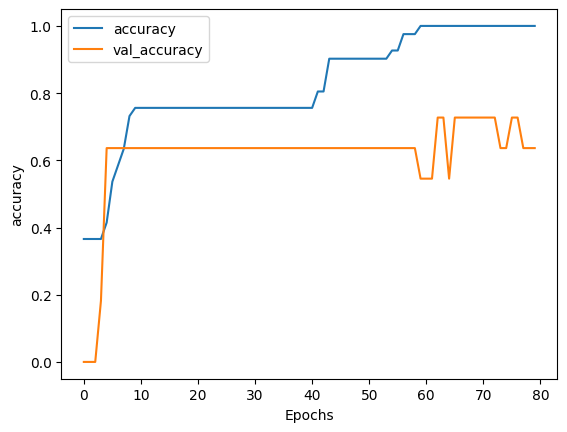

In [18]:
transformation.plot_graphs(history, "accuracy")

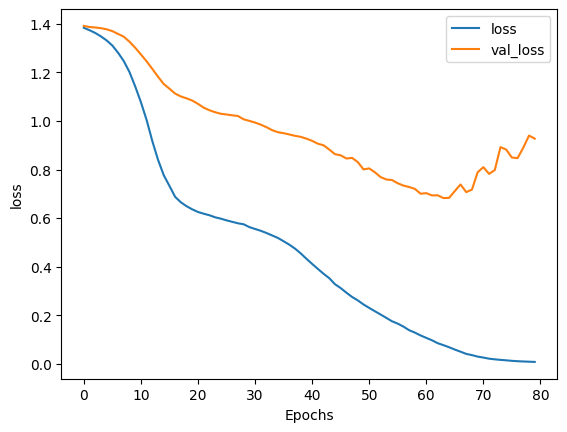

In [19]:
transformation.plot_graphs(history, "loss")

In [20]:
if LOG_MODEL_RUN:
    # log a model run
    log_dict = {
        "params": model_config,
        "metrics": {
            "accuracy": history.history["accuracy"][-1],
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "val_accuracy": history.history["val_accuracy"][-1],
        },
    }

    extra_artifacts = {
        "tokenizer": {
            "local_path": tokenizer_path,
            "save_path": "data"
        }
    }

    run_id = mlflow.log_experiment_run(
        model=model,
        experiment_name="NLP Experiments",
        run_name=f"RNN: first_run",
        log_dict=log_dict,
        registered_model_name="rnn_experiments",
        extra_artifacts=extra_artifacts,
        tags={"model": "deep_learning"},
    )

[2023-08-22 17:13:59 +0200] [52127] [INFO] Starting gunicorn 21.2.0
[2023-08-22 17:13:59 +0200] [52127] [INFO] Listening at: http://0.0.0.0:9999 (52127)
[2023-08-22 17:13:59 +0200] [52127] [INFO] Using worker: sync
[2023-08-22 17:13:59 +0200] [52128] [INFO] Booting worker with pid: 52128
[2023-08-22 17:13:59 +0200] [52129] [INFO] Booting worker with pid: 52129
[2023-08-22 17:14:00 +0200] [52131] [INFO] Booting worker with pid: 52131
[2023-08-22 17:14:00 +0200] [52132] [INFO] Booting worker with pid: 52132
2023/08/22 17:14:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/Users/gokasci/Desktop/reports/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recomm

[2023-08-22 17:21:55 +0200] [52129] [INFO] Worker exiting (pid: 52129)
[2023-08-22 17:21:55 +0200] [52127] [INFO] Handling signal: term
[2023-08-22 17:21:55 +0200] [52128] [INFO] Worker exiting (pid: 52128)
[2023-08-22 17:21:55 +0200] [52131] [INFO] Worker exiting (pid: 52131)
[2023-08-22 17:21:55 +0200] [52132] [INFO] Worker exiting (pid: 52132)
[2023-08-22 17:21:55 +0200] [52127] [ERROR] Worker (pid:52129) was sent SIGTERM!
[2023-08-22 17:21:55 +0200] [52127] [INFO] Shutting down: Master
